**Trabajo2 Presentado por Esteban Garcia Solis**

In [0]:
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**1) Implemente el algoritmo de Kittler, y realice una prueba con la imagen de entrada provista, aplicando posteriormente el umbral óptimo obtenido.**

In [0]:
#Value to prevent error on ln calculations
LOW_VAL = 0.000001

def sum_bound(i, T, L):
  """
  Used to calculate the summation bounds (a,b)
  i: P1 or P2
  T: Candidate umbral
  L: Amount of histogram bins
  """
  if i == 1:
    return (0, T + 1)
  elif i == 2:
    return (T, L)
  
  
def calc_Pi(i, T, L, hist):
  """
  To calculate Pi
  i: P1 or P2
  T: Candidate umbral
  L: Amount of histogram bins
  hist: histogram array
  """  
  a, b = sum_bound(i, T, L)
  
  sum = 0
  
  for z in range (a, b):
    sum += hist[z]
    
  return sum

def calc_mui(i, T, L, hist):
  """
  To calculate mu
  i: mu1 or mu2
  T: Candidate umbral
  L: Amount of histogram bins
  hist: histogram array  
  """  
  a, b = sum_bound(i, T, L)  
  Pi = calc_Pi(i, T, L, hist) + LOW_VAL
  sum = 0
  
  for z in range (a, b):
    sum += hist[z] * z
    
  return sum / Pi
    
def calc_sigmmai(i, T, L, hist):
  """
  To calculate sigmma
  i: sigmma1 or sigmma2
  T: Candidate umbral
  L: Amount of histogram bins
  hist: histogram array  
  """  
  a, b = sum_bound(i, T, L)  
  Pi = calc_Pi(i, T, L, hist) + LOW_VAL
  mui = calc_mui(i, T, L, hist)
  
  sum = LOW_VAL
  
  for z in range (a, b):
    sum += hist[z] * ((z - mui) ** 2)
    
  return (sum / Pi, mui)


def calc_J(T, L, hist):  
  """
  To calculate J
  T: Candidate umbral
  L: Amount of histogram bins
  hist: histogram array  
  """  
  P1 = calc_Pi(1, T, L, hist) + LOW_VAL
  (sigmma1, mu1) = calc_sigmmai(1, T, L, hist) 
  
  P2 = calc_Pi(2, T, L, hist) + LOW_VAL
  (sigmma2, mu2) = calc_sigmmai(2, T, L, hist) 
  
  j = 1 + 2 * P1 * np.log(sigmma1) - 2 * P1 * np.log(P1)  \
        + 2 * P2 * np.log(sigmma2) - 2 * P2 * np.log(P2)
  
  return (j, sigmma1, mu1, sigmma2, mu2)

def find_t(hist):
  """
  Find best t
  hist: histogram
  """
  J = []
  L = len(hist)
  
  tmin = 0 
  (jmin, sigmma1min, mu1min, sigmma2min, mu2min) = calc_J(0, L, hist)

  for t in range(0, L):

    (j, sigmma1, mu1, sigmma2, mu2) = calc_J(t, L, hist)
    J.append(j)
    
    if j < jmin:
      tmin = t
      jmin = j
      mu1min = mu1
      sigmma1min = sigmma1
      mu2min = mu2
      sigmma2min = sigmma2
      
  return (tmin, sigmma1min, mu1min, sigmma2min, mu2min, J)

> 1.a)Aplique el algoritmo de Kittler en la imagen cuadro1_005.bmp, provista.
 
> > 1.a.1) Abra la imagen como una matriz con pixeles de 8 bits (valores de 0 a 255).

In [0]:
img = Image.open('/content/drive/My Drive/Colab Notebooks/Resources/cuadro1_005.bmp').convert('L')

> > 1.a.2) Grafique el histograma normalizado de la imagen de entrada provista.


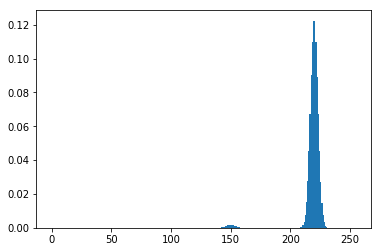

In [5]:
pix_val = list(img.getdata())
(hist, bins, patches) = plt.hist(pix_val, np.arange(0, 256), density=True)
plt.show()


> > 1.a.3) Grafique la función J(T), y documente el valor T = τ que logra el valor mínimo de J(T), junto con las medias y varianzas de
las dos funciones Gaussianas superpuestas. Son coherentes tales valores con el histograma graficado en el punto anterior? 



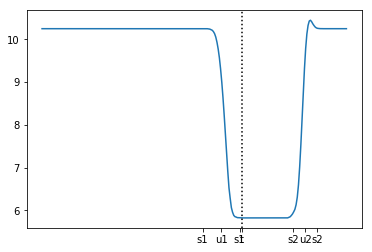

T:  167
mu1:  149.44392535871896
mu2:  219.49244262768124
sigmma1:  15.365713064387208
sigmma2:  10.054684250860664


In [6]:
(t, sigmma1, mu1, sigmma2, mu2, J) = find_t(hist)
plt.plot(np.arange(0,len(hist)), J)
values = [mu1 - sigmma1, mu1, mu1 + sigmma1, t, mu2 - sigmma2, mu2, mu2 + sigmma2]
plt.xticks(values, ["s1","u1","s1","t","s2","u2","s2"])

plt.axvline(t, linestyle = ":", color="black")
  
plt.show()
print("T: ", t)
print("mu1: ", mu1)
print("mu2: ", mu2)
print("sigmma1: ", sigmma1)
print("sigmma2: ", sigmma2)

> > *R/Los valores son consistentes con el histograma, se puede ver como el error se mimimiza en el segmento donde las curvas se separan, con un valor T = 167*

> 1.b) Lograría el umbral óptimo τ obtenido umbralizar satisfactoriamente la imagen de prueba? Umbralice la imagen de entrada provista y
muestre los resultados.

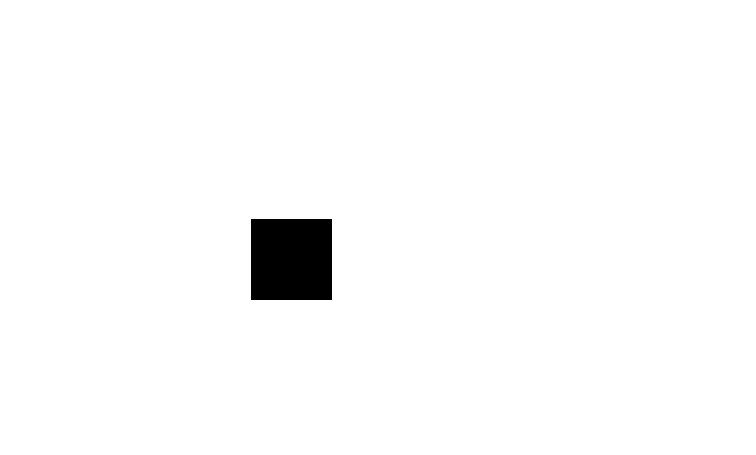

In [7]:
def evaluatePixel(color, t):
  if color < t:
    return 0
  else:
    return 255
  
def thresholdImage(img, t):
    newImgData = []
    
    for pix in pix_val:
      newImgData.append(evaluatePixel(pix, t))
      
    newImg = Image.new(img.mode,img.size)
    
    newImg.putdata(newImgData)
    return newImg
  
newImg = thresholdImage(img, t)
newImg


> *R/ En la imagen de prueba se ve como el algoritmo cumplio su función y el background y foreground de la imagen cuadro1_005.bmp estan correctamente separados*

**2) Calcule el umbral óptimo con el algoritmo de Kittler, y umbralice la imagen de trackedCell15.tif provista documentando los resultados.**


In [0]:
img = Image.open('/content/drive/My Drive/Colab Notebooks/Resources/trackedCell15.tif').convert('L')
pix_val = list(img.getdata())

> 2.a) Grafique el histograma de tal imagen.

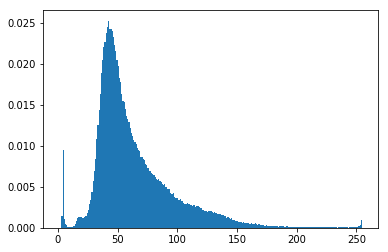

T:  73
mu1:  47.02170860107931
mu2:  105.91610388205687
sigmma1:  175.56008142370956
sigmma2:  1000.6609188655445


In [9]:
(hist, bins, patches) = plt.hist(pix_val, np.arange(0, 256), density=True)

plt.show()

(t, sigmma1, mu1, sigmma2, mu2, J) = find_t(hist)

print("T: ", t)
print("mu1: ", mu1)
print("mu2: ", mu2)
print("sigmma1: ", sigmma1)
print("sigmma2: ", sigmma2)

> 2.b) Muestre al imagen umbralizada.

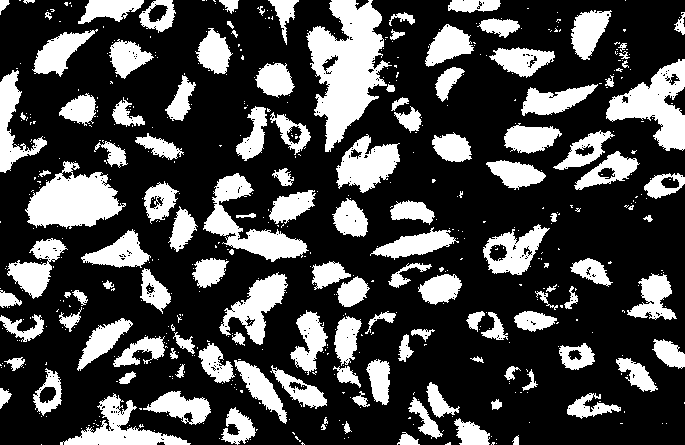

In [10]:
thresholdImage(img, t)

> 2.c) Explique, usando el histograma de la imagen, porqué el funcionamiento es el obtenido.

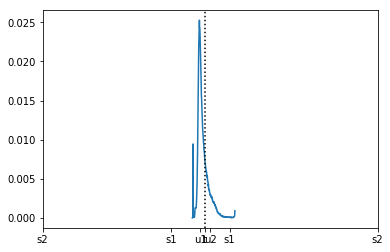

T:  73
mu1:  47.02170860107931
mu2:  105.91610388205687
sigmma1:  175.56008142370956
sigmma2:  1000.6609188655445


In [11]:
plt.plot(np.arange(0,len(hist)), hist)
values = [mu1 - sigmma1, mu1, mu1 + sigmma1, t, mu2 - sigmma2, mu2, mu2 + sigmma2]
plt.xticks(values, ["s1","u1","s1","t","s2","u2","s2"])

plt.axvline(t, linestyle = ":", color="black")
  
plt.show()
print("T: ", t)
print("mu1: ", mu1)
print("mu2: ", mu2)
print("sigmma1: ", sigmma1)
print("sigmma2: ", sigmma2)

> *R/ En este caso se puede ver que las distribuciones no están claramente divididas, las medias son muy cercanas y el valor de sigmma2 es muy alto, por lo que las distribuciones se mezclan. Esto da como resultado que en la imagen no se separen claramente los núcleos de las células*

> 2.d) ¿Que enfoque implementaría para mejorar el resultado de la umbralización?

> *R\Aplicar el algoritmo iterativamente sobre un vecindario alrededor de cada pixel de forma que T se defina con respecto a lo que se encuentra alredodor de un punto especifico y no de forma global para todos los pixeles*